In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init


id_max = 214200
item_cnt_max = 20
month_max=33

test_file = open('/content/drive/My Drive/Colab Notebooks/competitive-data-science-predict-future-sales/test.csv',encoding='UTF8')
test_file.readline()
test= test_file.readlines()
test_file.close()

sales_train_file = open('/content/drive/My Drive/Colab Notebooks/competitive-data-science-predict-future-sales/sales_train.csv')
sales_train_file.readline()
sales_train = sales_train_file.readlines()
sales_train_file.close()



#id 생성
IDs={}
for line in test:
    ID, shop_id, item_id =map(int, line.split(','))
    IDs[str(shop_id)+' '+str(item_id)]=ID

x_train= torch.zeros(id_max, month_max)
y_train= torch.zeros(id_max,1)
#0개월부터 33까지 묶고, 34개월째는 답으로
for line in sales_train:
    _, month, shop_id, item_id,_, item_cnt_day =line.split(',')

    if shop_id+" "+item_id in IDs: 
      if int(month) < month_max: x_train[IDs[shop_id+" "+item_id]][int(month)]+=float(item_cnt_day)
      else: y_train[IDs[shop_id+" "+item_id]]+=float(item_cnt_day)
  

    

In [ ]:
x_train.size()

torch.Size([214200, 33])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_epoch = 1000
lr=0.0001


model = nn.Sequential(
            nn.Linear(month_max,200),
            nn.ReLU(),
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)).to(device)

loss_func= nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

loss_array=[]

x_train= x_train.to(device)
y_train= y_train.to(device)
for i in range(num_epoch):
    optimizer.zero_grad()
    output= model(x_train)
    loss= loss_func(output,y_train)
    loss.backward()
    optimizer.step()
    print('done',i)
    loss_array.append(loss)
    

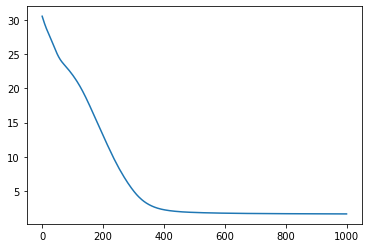

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_array)
plt.show()

In [ ]:
#1개월 째 부터 34개월째 까지의 값
x_test= torch.zeros(id_max, month_max)
for line in sales_train:
    _, month, shop_id, item_id,_, item_cnt_day =line.split(',')

    if shop_id+" "+item_id in IDs:
      if 1 < int(month) <= month_max: x_test[IDs[shop_id+" "+item_id]][int(month)-1]+=float(item_cnt_day)
x_test= x_test.to(device)
output_test= model(x_test)


In [ ]:
output_test.size()

torch.Size([214200, 1])

In [ ]:
import csv
with torch.no_grad():
  f = open('output.csv', 'w', encoding='utf-8')
  wr = csv.writer(f)
  wr.writerow(['ID','item_cnt_month'])
  for i in range(214200):
    wr.writerow([i,output_test[i].item()])
  f.close()
